# Support Vector Machines
---

In [434]:
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.io as sio
import matplotlib.pyplot as plt

#from sklearn import svm
#from sklearn import metrics
#from sklearn.grid_search import GridSearchCV
#from sklearn.linear_model import LogisticRegression

# Loading and Visualizing Data
---
We start the exercise by first loading and visualizing the dataset.   
The following code will load the dataset into your environment and plot the data.

In [93]:
# Loading and Visualizing Data
# Load from ex6data1: You will have X, y in your environment
mat = sio.loadmat('ex6data1.mat');
mat.keys()

dict_keys(['__header__', '__version__', '__globals__', 'X', 'y'])

In [94]:
data = pd.DataFrame(mat.get('X'), columns=['X1', 'X2']);
data['y'] = mat.get('y');
data.head()

,X1,X2,y
0,1.9643,4.5957,1
1,2.2753,3.8589,1
2,2.9781,4.5651,1
3,2.9320,3.5519,1
4,3.5772,2.8560,1


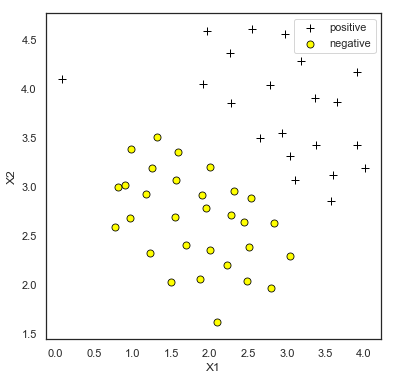

In [95]:
# plots the data points with + for the positive examples and o for the negative examples. 
# X is assumed to be a Mx2 matrix.
sns.set(context="notebook", style="white")

positive = data[data['y'].isin([1])]
negative = data[data['y'].isin([0])]

fig, ax = plt.subplots(figsize=(6,6))
ax.scatter(positive['X1'], positive['X2'], linewidth=1, s=50, c='black', marker='+', label='positive')
ax.scatter(negative['X1'], negative['X2'], linewidth=0.8, s=50, c='yellow',edgecolors='black', marker='o', label='negative')
ax.legend(loc=0)
ax.set_xlabel('X1')
ax.set_ylabel('X2')
plt.show()

# Training Linear SVM
---
The following code will train a linear SVM on the dataset and plot the decision boundary learned.

In [435]:
# returns a linear kernel between x1 and x2 and returns the value in sim
def linearKernel(x1, x2):
    # Ensure that x1 and x2 are column vectors
    x1 = np.ravel(x1);
    x2 = np.ravel(x2);
    # Compute the kernel
    #return x1.T @ x2
    return x1.T @ x2

In [436]:
def svmTrain(X, Y, C, kernel='linear', sigma=2, tol=1e-3, max_passes=5):

# SVMTRAIN Trains an SVM classifier using a simplified version of the SMO algorithm and returns trained model. 
#
# X is the matrix of training examples.  
# Each row is a training example, and the jth column holds the jth feature.  
# Y is a column matrix containing 1 for positive examples and 0 for negative examples.  
# C is the standard SVM regularization parameter.  
# tol is a tolerance value used for determining equality of floating point numbers. 
# max_passes controls the number of iterations over the dataset (without changes to alpha) before the algorithm quits.
#
# Note: This is a simplified version of the SMO algorithm for training SVMs. 
#       In practice, if you want to train an SVM classifier, we recommend using an optimized package such as:  
#           LIBSVM   (http://www.csie.ntu.edu.tw/~cjlin/libsvm/)
#           SVMLight (http://svmlight.joachims.org/)
#
   
    # Data parameters
    m, n = X.shape

    # Map 0 to -1
    Y = Y+(-1)+Y

    # Variables
    alphas = np.zeros([m, 1]);
    b = 0;
    E = np.zeros([m, 1]);
    passes = 0;
    eta = 0;
    L = 0;
    H = 0;

    # Pre-compute the Kernel Matrix since our dataset is small
    # (in practice, optimized SVM packages that handle large datasets gracefully will _not_ do this)
    # 
    # We have implemented optimized vectorized version of the Kernels here 
    # so that the svm training will run faster.
    if kernel == 'linear':
        # Vectorized computation for the Linear Kernel
        # This is equivalent to computing the kernel on every pair of examples
        K = X @ X.T;
    elif kernel == 'gaussian':
        # Vectorized RBF Kernel
        # This is equivalent to computing the kernel on every pair of examples
        X2 = np.array([np.sum(np.power(X, 2), 1)]).T
        K = X2.T - 2 * (X @ X.T)
        K = X2 + K
        K = np.power(gaussianKernel(1, 0, sigma), K)
    else:
        # Pre-compute the Kernel Matrix
        # The following can be slow due to the lack of vectorization
        K = np.zeros([m, m]);
        for i in range(m):
            for j in range(m):
                 K[i,j] = linearKernel(X[i,:].T, X[j,:].T);
                 #K[i,j] = gaussianKernel(X[i,:].T, X[j,:].T, sigma); 
                 K[j,i] = K[i,j]; # the matrix is symmetric

    # Train
    print('\nTraining ...');
    dots = 12;
    while passes < max_passes:

        num_changed_alphas = 0;
        for i in range(m):

            # Calculate Ei = f(x(i)) - y(i) using (2). 
            # E(i) = b + sum (X(i, :) * (repmat(alphas.*Y,1,n).*X)') - Y(i);
            E[i] = b + np.sum(np.multiply(np.multiply(alphas, Y), K[:,i:i+1])) - Y[i];
            if (Y[i]*E[i] < -tol and alphas[i] < C) or (Y[i]*E[i] > tol and alphas[i] > 0):

                # In practice, there are many heuristics one can use to select
                # the i and j. In this simplified code, we select them randomly.
                j = int(np.ceil((m-1) * np.random.rand()));
                while j == i:  # Make sure i \neq j
                    j = int(np.ceil((m-1) * np.random.rand()));

                # Calculate Ej = f(x(j)) - y(j) using (2).

                E[j] = b + np.sum(np.multiply(np.multiply(alphas, Y), K[:,j:j+1])) - Y[j];

                # Save old alphas
                alpha_i_old = alphas[i].copy();
                alpha_j_old = alphas[j].copy();

                # Compute L and H by (10) or (11). 
                if Y[i] == Y[j]:
                    var_list = alphas[j] + alphas[i] - C
                    L = (0>=var_list) * 0 + (0<var_list) * var_list # equal Octave's max()

                    var_list = alphas[j] + alphas[i]
                    H = (C<var_list) * C + (C>=var_list) * var_list # equal Octave's min()
                else:
                    var_list = alphas[j] - alphas[i]
                    L = (0>=var_list) * 0 + (0<var_list) * var_list # equal Octave's max()

                    var_list = alphas[j] - alphas[i] + C
                    H = (C<var_list) * C + (C>=var_list) * var_list # equal Octave's min()     

                if L == H:
                    # continue to next i. 
                    continue;

                # Compute eta by (14).
                eta = 2 * K[i,j] - K[i,i] - K[j,j];
                
                if eta >= 0:
                    #% continue to next i. 
                    continue;

                # Compute and clip new value for alpha j using (12) and (15).
                alphas[j] = alphas[j] - (Y[j] * (E[i] - E[j])) / eta;

                # Clip
                var_list = alphas[j]
                alphas[j] = (H<var_list) * H + (H>=var_list) * var_list # equal Octave's min()   

                var_list = alphas[j]
                alphas[j] = (L>=var_list) * L + (L<var_list) * var_list # equal Octave's max()
                
                # Check if change in alpha is significant
                if np.abs(alphas[j] - alpha_j_old) < tol:
                    # continue to next i. 
                    # replace anyway
                    alphas[j] = alpha_j_old.copy();
                    continue;
                # Determine value for alpha i using (16). 
                alphas[i] = alphas[i] + Y[i]*Y[j]*(alpha_j_old - alphas[j]);

                # Compute b1 and b2 using (17) and (18) respectively. 
                b1 = b - E[i] \
                     - Y[i] * (alphas[i] - alpha_i_old) *  K[i,j].T \
                     - Y[j] * (alphas[j] - alpha_j_old) *  K[i,j].T;
                b2 = b - E[j] \
                     - Y[i] * (alphas[i] - alpha_i_old) *  K[i,j].T \
                     - Y[j] * (alphas[j] - alpha_j_old) *  K[j,j].T;

                # Compute b by (19). 
                if 0 < alphas[i] and alphas[i] < C:
                    b = b1;
                elif 0 < alphas[j] and alphas[j] < C:
                    b = b2;
                else:
                    b = (b1+b2)/2;

                num_changed_alphas = num_changed_alphas + 1;

        if num_changed_alphas == 0:
            passes = passes + 1;
        else:
            passes = 0;

        print('.', end='');
        dots = dots + 1;
        if dots > 78:
            dots = 0;
            print('\n');
    print(' Done! \n\n');
    
    # Save the model
    model = {}
    idx = np.where(alphas>0)[0];
    model['X'] = X[idx,:]
    model['y'] = Y[idx];
    model['kernelFunction'] = kernel;
    model['sigma'] = sigma;
    model['b'] = b;
    model['alphas'] = alphas[idx];
    model['w'] = (np.multiply(alphas, Y).T @ X).T;
    
    return model

In [98]:
# Loading and Visualizing Data
# Load from ex6data1: You will have X, y in your environment
mat = sio.loadmat('ex6data1.mat');
X = mat.get('X')
y = mat.get('y')

# You should try to change the C value below 
# and see how the decision boundary varies (e.g., try C = 1000)
model1 = svmTrain(X, y, C=1,    kernel='linear', sigma=0.1, tol=1e-3, max_passes=20)
model2 = svmTrain(X, y, C=10,   kernel='linear', sigma=0.1, tol=1e-3, max_passes=20)
model3 = svmTrain(X, y, C=100,  kernel='linear', sigma=0.1, tol=1e-3, max_passes=20)
model4 = svmTrain(X, y, C=1000, kernel='linear', sigma=0.1, tol=1e-3, max_passes=20)


Training ...
...................................................................

.................................... Done! 



Training ...
...................................................................

...............................................................................

...............................................................................

...............................................................................

...............................................................................

......................................................... Done! 



Training ...
...................................................................

...............................................................................

...............................................................................

...............................................................................

.......................................................................

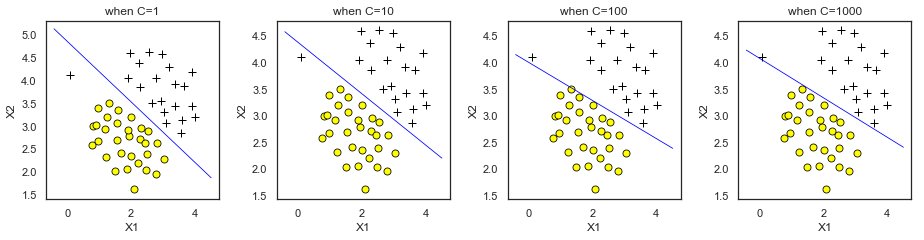

In [99]:
#fig, ax = plt.subplots(figsize=(6,6))
fig = plt.figure(num=1, figsize=(13,3.5))

ax1 = fig.add_subplot(141)
# plots the data points
ax1.scatter(positive['X1'], positive['X2'], linewidth=1, s=50, c='black', marker='+', label='positive')
ax1.scatter(negative['X1'], negative['X2'], linewidth=0.8, s=50, c='yellow',edgecolors='black', marker='o', label='negative')
#ax1.legend(loc=3)
ax1.set_xlabel('X1')
ax1.set_ylabel('X2')
ax1.set_title('when C=1')
# plots a linear decision boundary learned by the SVM and overlays the data on it
w = model1['w'];
b = model1['b'];
x1 = np.linspace(np.min(X[:,0]) - 0.5, np.max(X[:,0]) + 0.5, 2);
x2 = - (w[0] * x1 + b) / w[1];
plt.plot(x1, x2, c='Blue', linewidth=0.8, label='Decision Boundary')

ax2 = fig.add_subplot(142)
# plots the data points
ax2.scatter(positive['X1'], positive['X2'], linewidth=1, s=50, c='black', marker='+', label='positive')
ax2.scatter(negative['X1'], negative['X2'], linewidth=0.8, s=50, c='yellow',edgecolors='black', marker='o', label='negative')
#ax2.legend(loc=3)
ax2.set_xlabel('X1')
ax2.set_ylabel('X2')
ax2.set_title('when C=10')
# plots a linear decision boundary learned by the SVM and overlays the data on it
w = model2['w'];
b = model2['b'];
x1 = np.linspace(np.min(X[:,0]) - 0.5, np.max(X[:,0]) + 0.5, 2);
x2 = - (w[0] * x1 + b) / w[1];
plt.plot(x1, x2, c='Blue', linewidth=0.8, label='Decision Boundary')

ax3 = fig.add_subplot(143)
# plots the data points
ax3.scatter(positive['X1'], positive['X2'], linewidth=1, s=50, c='black', marker='+', label='positive')
ax3.scatter(negative['X1'], negative['X2'], linewidth=0.8, s=50, c='yellow',edgecolors='black', marker='o', label='negative')
#ax3.legend(loc=3)
ax3.set_xlabel('X1')
ax3.set_ylabel('X2')
ax3.set_title('when C=100')
# plots a linear decision boundary learned by the SVM and overlays the data on it
w = model3['w'];
b = model3['b'];
x1 = np.linspace(np.min(X[:,0]) - 0.5, np.max(X[:,0]) + 0.5, 2);
x2 = - (w[0] * x1 + b) / w[1];
plt.plot(x1, x2, c='Blue', linewidth=0.8, label='Decision Boundary')

ax4 = fig.add_subplot(144)
# plots the data points
ax4.scatter(positive['X1'], positive['X2'], linewidth=1, s=50, c='black', marker='+', label='positive')
ax4.scatter(negative['X1'], negative['X2'], linewidth=0.8, s=50, c='yellow',edgecolors='black', marker='o', label='negative')
#ax4.legend(loc=3)
ax4.set_xlabel('X1')
ax4.set_ylabel('X2')
ax4.set_title('when C=1000')
# plots a linear decision boundary learned by the SVM and overlays the data on it
w = model4['w'];
b = model4['b'];
x1 = np.linspace(np.min(X[:,0]) - 0.5, np.max(X[:,0]) + 0.5, 2);
x2 = - (w[0] * x1 + b) / w[1];
plt.plot(x1, x2, c='Blue', linewidth=0.8, label='Decision Boundary')

fig.tight_layout()

plt.show()

# Implementing Gaussian Kernel
---
You will now implement the Gaussian kernel to use with the SVM. You should complete the code in gaussianKernel

In [437]:
#  Evaluating the Gaussian Kernel
def gaussianKernel(x1, x2, sigma):
    #  returns a gaussian kernel between x1 and x2 and returns the value in sim
    #  Ensure that x1 and x2 are row vectors x1 = x1(:); x2 = x2(:);
    x1 = np.ravel(x1);
    x2 = np.ravel(x2);
    # return the similarity between x1 and x2 computed 
    # using a Gaussian kernel with bandwidth sigma
    return np.exp(-np.sum(np.power(x1-x2, 2))/2/sigma/sigma)

In [101]:
x1=np.array([[1],[2],[1]]);
x2=np.array([[0],[4],[-1]]);
sigma=2;
sim = gaussianKernel(x1, x2, sigma); 
print('Gaussian Kernel between x1 = [[1],[2],[1]], x2 = [[0],[4],[-1]], sigma = {0} : \n\t{1}\n(for sigma = {0}, this value should be about 0.324652)\n'.format(sigma, sim));

Gaussian Kernel between x1 = [[1],[2],[1]], x2 = [[0],[4],[-1]], sigma = 2 : 
	0.32465246735834974
(for sigma = 2, this value should be about 0.324652)



# Visualizing Dataset 2
---
The following code will load the next dataset into your environment and plot the data. 

In [242]:
# Loading and Visualizing Data
# Load from ex6data2: You will have X, y in your environment
mat = sio.loadmat('ex6data2.mat');
X = mat.get('X')
y = mat.get('y')
mat.keys()

dict_keys(['__header__', '__version__', '__globals__', 'X', 'y'])

In [243]:
data = pd.DataFrame(mat.get('X'), columns=['X1', 'X2']);
data['y'] = mat.get('y');
data.head()

,X1,X2,y
0,0.107143,0.603070,1
1,0.093318,0.649854,1
2,0.097926,0.705409,1
3,0.155530,0.784357,1
4,0.210829,0.866228,1


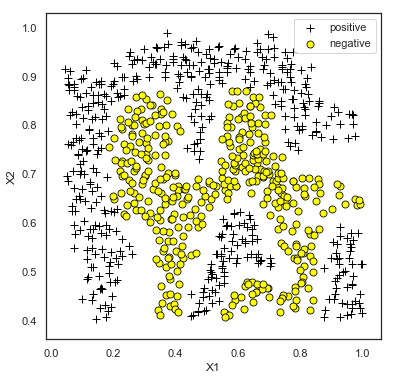

In [244]:
# plots the data points with + for the positive examples and o for the negative examples. 
# X is assumed to be a Mx2 matrix.
sns.set(context="notebook", style="white")

positive = data[data['y'].isin([1])]
negative = data[data['y'].isin([0])]

fig, ax = plt.subplots(figsize=(6,6))
ax.scatter(positive['X1'], positive['X2'], linewidth=1, s=50, c='black', marker='+', label='positive')
ax.scatter(negative['X1'], negative['X2'], linewidth=0.8, s=50, c='yellow',edgecolors='black', marker='o', label='negative')
ax.legend(loc=0)
ax.set_xlabel('X1')
ax.set_ylabel('X2')
plt.show()

# Training SVM with RBF Kernel (Dataset 2)
---
After you have implemented the kernel, we can now use it to train the SVM classifier. Training SVM with RBF Kernel (this may take 1 to 2 minutes) ...

In [271]:
model = svmTrain(X, y, C=1, kernel='gaussian', sigma=0.1, tol=1e-3, max_passes=5)


Training ...
...................................................................

...............................................................................

...............................................................................

...............................................................................

...............................................................................

...............................................................................

.................................................... Done! 




In [266]:
model.keys() # linear gaussian

dict_keys(['X', 'y', 'kernelFunction', 'sigma', 'b', 'alphas', 'w'])

In [438]:
def svmPredict(model, X):
    # Returns a vector of predictions using a trained SVM model (svmTrain). 
    # X is a mxn matrix where there each example is a row. 
    # model is a svm model returned from svmTrain.
    # predictions pred is a m x 1 column of predictions of {0, 1} values.
    #

    # Check if we are getting a column vector, 
    # if so, then assume that we only need to do prediction for a single example
    if X.shape[1] == 1:
        X = X.T; # Examples should be in rows

    # Dataset 
    m = X.shape[0];
    p = np.zeros([m, 1]);
    pred = p.copy();

    if model['kernelFunction'] == 'linear':
        # We can use the weights and bias directly if working with the linear kernel
        p = X @ model['w'] + model['b'];
    elif model['kernelFunction'] == 'gaussian':
        # Vectorized RBF Kernel
        # This is equivalent to computing the kernel on every pair of examples
        X1 = np.array([np.sum(np.power(X, 2), axis=1)]).T;
        X2 = np.sum(np.power(model['X'], 2), axis=1).T;
        K = (-2) * (X @ model['X'].T) + X2 + X1;
        K = np.power(gaussianKernel(1, 0, model['sigma']), K);
        K = np.multiply(model['y'].T, K)
        K = np.multiply(model['alphas'].T, K);
        p = np.sum(K, axis=1);
    else:
        # Other Non-linear kernel  该部分代码未验证过
        for i in range(m):
            prediction = 0;
            for j in range(model['X'].shape[0]):
                prediction = prediction + model['alphas'][j] @ model['y'][j] @ gaussianKernel(X[i,:].T, model['X'][j,:].T, model['sigma']);
            p[i] = prediction + model['b'];

    # Convert predictions into 0 / 1
    pred[np.where(p>=0)[0]] = 1;
    pred[np.where(p< 0)[0]] = 0;

    return pred

<IPython.core.display.Javascript object>


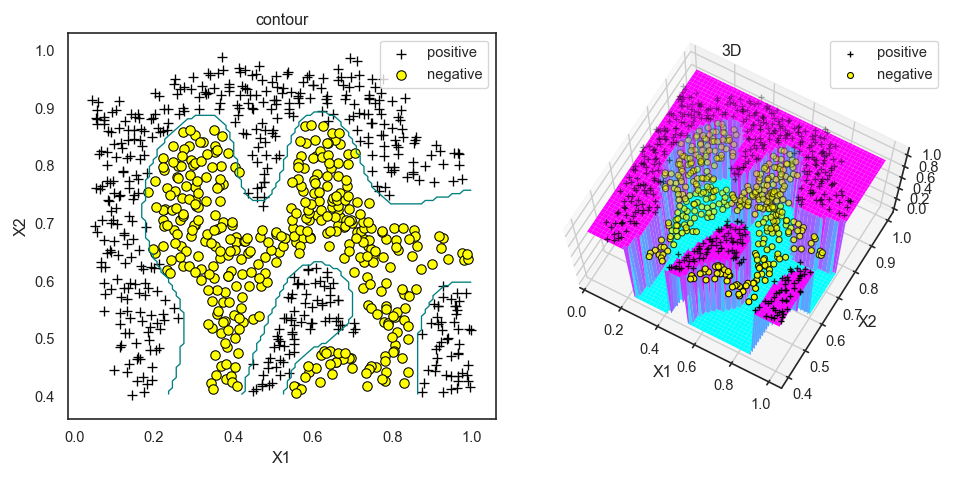

In [325]:
%matplotlib notebook
#%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D

positive = data[data['y'].isin([1])]
negative = data[data['y'].isin([0])]

fig = plt.figure(dpi=80, figsize=(10,5))
ax1 = fig.add_subplot(121)
ax1.scatter(positive['X1'], positive['X2'], linewidth=1, s=50, c='black', marker='+', label='positive')
ax1.scatter(negative['X1'], negative['X2'], linewidth=0.8, s=50, c='yellow',edgecolors='black', marker='o', label='negative')
ax1.legend(loc=0)
ax1.set_xlabel('X1')
ax1.set_ylabel('X2')
ax1.set_title('contour')
# Make classification predictions over a grid of values
X1 = np.mgrid[np.min(X[:,0]):np.max(X[:,0]):100j]
X2 = np.mgrid[np.min(X[:,1]):np.max(X[:,1]):100j]
vals = np.zeros([100, 100])
for i in range(100):
    for j in range(100):
        this_X = np.vstack((X1[i], X2[j])).T
        vals[i, j] = svmPredict(model, this_X);
ax1.contour(X1, X2, vals.T, [1], linewidths=1, colors='teal')

ax2 = fig.add_subplot(122, projection='3d')
ax2.scatter(positive['X1'], positive['X2'], 1.05, linewidth=1, s=20, c='black', marker='+', label='positive')
ax2.scatter(negative['X1'], negative['X2'], 1.05, linewidth=0.8, s=20, c='yellow',edgecolors='black', marker='o', label='negative')
ax2.legend(loc=0)
ax2.set_xlabel('X1')
ax2.set_ylabel('X2')
ax2.set_title('3D')
X3, X4 = np.mgrid[np.min(X[:,0]):np.max(X[:,0]):100j, np.min(X[:,1]):np.max(X[:,1]):100j]
X3 = X3.T; X4 = X4.T;
ax2.plot_surface(X3, X4, vals.T, linewidth=0.2, edgecolors = 'none', cmap=plt.cm.cool)

fig.tight_layout()
plt.show()

# Visualizing Dataset 3
---
The following code will load the next dataset into your environment and  plot the data. 

In [440]:
# Loading and Visualizing Data
# Load from ex6data3: You will have X, y ,yval, Xval in your environment
mat = sio.loadmat('ex6data3.mat');
X = mat.get('X')
y = mat.get('y')
Xval = mat.get('Xval')
yval = mat.get('yval')
mat.keys()

dict_keys(['__header__', '__version__', '__globals__', 'X', 'y', 'yval', 'Xval'])

In [441]:
data = pd.DataFrame(mat.get('X'), columns=['X1', 'X2']);
data['y'] = mat.get('y');
data.head()

,X1,X2,y
0,-0.158986,0.423977,1
1,-0.347926,0.470760,1
2,-0.504608,0.353801,1
3,-0.596774,0.114035,1
4,-0.518433,-0.172515,1


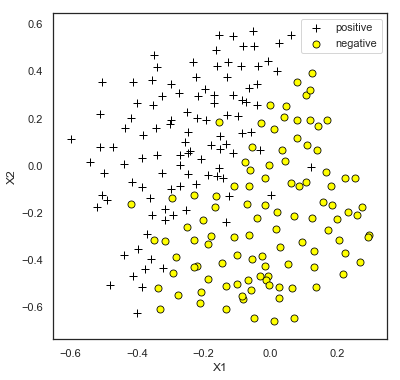

In [332]:
# plots the data points with + for the positive examples and o for the negative examples. 
# X is assumed to be a Mx2 matrix.
%matplotlib inline
sns.set(context="notebook", style="white")

positive = data[data['y'].isin([1])]
negative = data[data['y'].isin([0])]

fig, ax = plt.subplots(figsize=(6,6))
ax.scatter(positive['X1'], positive['X2'], linewidth=1, s=50, c='black', marker='+', label='positive')
ax.scatter(negative['X1'], negative['X2'], linewidth=0.8, s=50, c='yellow',edgecolors='black', marker='o', label='negative')
ax.legend(loc=0)
ax.set_xlabel('X1')
ax.set_ylabel('X2')
plt.show()

# Training SVM with RBF Kernel (Dataset 3)
---
This is a different dataset that you can use to experiment with.   
Try different values of C and sigma here.

In [448]:
def dataset3Params(X, y, Xval, yval):
    # Returns your choice of C and sigma for Part 3 of the exercise
    # where you select the optimal (C, sigma) learning parameters to use for SVM with RBF kernel.
    # You should complete this function to return the optimal C and sigma based on a cross-validation set.

    # You need to return the following variables correctly.
    C = 1;
    sigma = 0.3;

    # Instructions:
    # Fill in this function to return the optimal C and sigma learning parameters found using the cross validation set.
    # You can use svmPredict to predict the labels on the cross validation set. For example,
    # predictions = svmPredict(model, Xval);
    # will return the predictions on the cross validation set.
    # Note: You can compute the prediction error using mean(double(predictions ~= yval))
    wid = np.array([0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30, 100]);
    errors = np.zeros([wid.shape[0], wid.shape[0]]);
    for i in range(wid.shape[0]):
        for j in range(wid.shape[0]):
            model = svmTrain(X, y, C=wid[i], kernel='gaussian', sigma=wid[j], tol=1e-3, max_passes=5)
            predictions = svmPredict(model, Xval);
            errors[i,j] = np.mean((predictions != yval));

    error = np.min(errors);
    i, j = np.where(errors == error);
    C = wid[i];
    sigma = wid[j];

    return C, sigma, errors

In [449]:
# Try different SVM Parameters here
[C, sigma, errors] = dataset3Params(X, y, Xval, yval);

c:\workspace\installed\python\python36\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in power
c:\workspace\installed\python\python36\lib\site-packages\ipykernel_launcher.py:80: RuntimeWarning: invalid value encountered in multiply
c:\workspace\installed\python\python36\lib\site-packages\ipykernel_launcher.py:116: RuntimeWarning: invalid value encountered in less
c:\workspace\installed\python\python36\lib\site-packages\ipykernel_launcher.py:116: RuntimeWarning: invalid value encountered in greater_equal
c:\workspace\installed\python\python36\lib\site-packages\ipykernel_launcher.py:119: RuntimeWarning: invalid value encountered in greater_equal
c:\workspace\installed\python\python36\lib\site-packages\ipykernel_launcher.py:119: RuntimeWarning: invalid value encountered in less
c:\workspace\installed\python\python36\lib\site-packages\ipykernel_launcher.py:122: RuntimeWarning: invalid value encountered in less
c:\workspace\installed\python\python36\l


Training ...
...... Done! 



Training ...
........................................................... Done! 



Training ...
............................... Done! 



Training ...
................................................ Done! 



Training ...
.......................... Done! 



Training ...
.................................. Done! 



Training ...
..................................... Done! 



Training ...
................................................. Done! 



Training ...
....................................... Done! 



Training ...
...... Done! 



Training ...
............................................... Done! 



Training ...
.............................................................. Done! 



Training ...
...................................................................

. Done! 



Training ...
.......................................... Done! 



Training ...
........................................... Done! 



Training ...
...........................

...............................................................................

...............................................................................

...............................................................................

...............................................................................

...............................................................................

...............................................................................

...............................................................................

...............................................................................

.......... Done! 



Training ...
...................................................................

...............................................................................

...............................................................................

...............................................................................

......

...............................................................................

..... Done! 



Training ...
...................................................................

........ Done! 



Training ...
.......................................... Done! 



Training ...
............................. Done! 




In [452]:
C, sigma, errors, np.min(errors)

(array([1.]),
 array([0.1]),
 array([[0.565, 0.06 , 0.045, 0.145, 0.185, 0.185, 0.18 , 0.18 , 0.18 ],
        [0.565, 0.06 , 0.045, 0.14 , 0.18 , 0.18 , 0.185, 0.185, 0.185],
        [0.565, 0.06 , 0.045, 0.08 , 0.17 , 0.185, 0.185, 0.185, 0.185],
        [0.565, 0.06 , 0.035, 0.06 , 0.095, 0.18 , 0.18 , 0.185, 0.18 ],
        [0.565, 0.065, 0.03 , 0.07 , 0.075, 0.16 , 0.185, 0.185, 0.18 ],
        [0.565, 0.08 , 0.035, 0.075, 0.105, 0.09 , 0.185, 0.18 , 0.18 ],
        [0.565, 0.08 , 0.07 , 0.07 , 0.09 , 0.075, 0.165, 0.18 , 0.185],
        [0.565, 0.08 , 0.06 , 0.06 , 0.085, 0.09 , 0.095, 0.18 , 0.185],
        [0.565, 0.08 , 0.065, 0.065, 0.22 , 0.075, 0.075, 0.15 , 0.18 ]]),
 0.03)

In [393]:
# Train the SVM
model = svmTrain(X, y, C=C, kernel='gaussian', sigma=sigma, tol=1e-3, max_passes=5)


Training ...
...................................................................

...............................................................................

.................................................................. Done! 




<IPython.core.display.Javascript object>


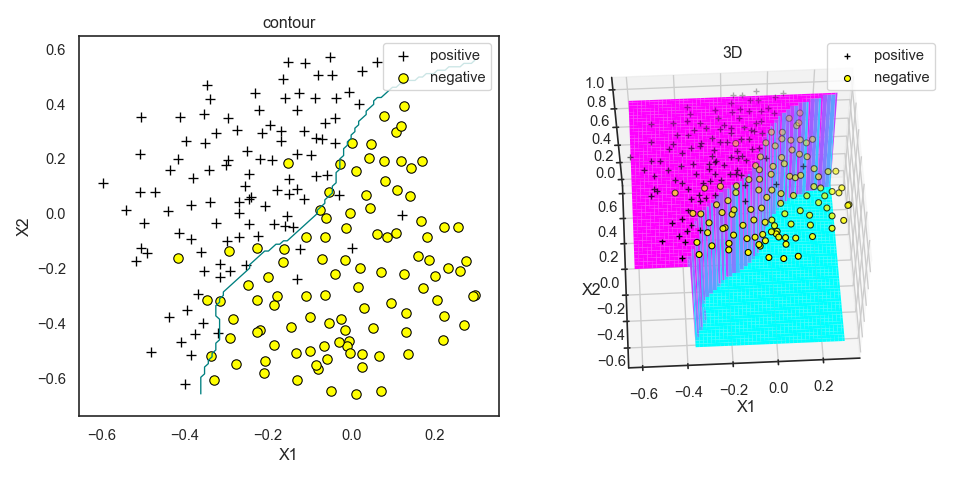

In [395]:
%matplotlib notebook
#%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D

positive = data[data['y'].isin([1])]
negative = data[data['y'].isin([0])]

fig = plt.figure(dpi=80, figsize=(10,5))
ax1 = fig.add_subplot(121)
ax1.scatter(positive['X1'], positive['X2'], linewidth=1, s=50, c='black', marker='+', label='positive')
ax1.scatter(negative['X1'], negative['X2'], linewidth=0.8, s=50, c='yellow',edgecolors='black', marker='o', label='negative')
ax1.legend(loc=0)
ax1.set_xlabel('X1')
ax1.set_ylabel('X2')
ax1.set_title('contour')
# Make classification predictions over a grid of values
X1 = np.mgrid[np.min(X[:,0]):np.max(X[:,0]):100j]
X2 = np.mgrid[np.min(X[:,1]):np.max(X[:,1]):100j]
vals = np.zeros([100, 100])
for i in range(100):
    for j in range(100):
        this_X = np.vstack((X1[i], X2[j])).T
        vals[i, j] = svmPredict(model, this_X);
ax1.contour(X1, X2, vals.T, [1], linewidths=1, colors='teal')

ax2 = fig.add_subplot(122, projection='3d')
ax2.scatter(positive['X1'], positive['X2'], 1.05, linewidth=1, s=20, c='black', marker='+', label='positive')
ax2.scatter(negative['X1'], negative['X2'], 1.05, linewidth=0.8, s=20, c='yellow',edgecolors='black', marker='o', label='negative')
ax2.legend(loc=0)
ax2.set_xlabel('X1')
ax2.set_ylabel('X2')
ax2.set_title('3D')
X3, X4 = np.mgrid[np.min(X[:,0]):np.max(X[:,0]):100j, np.min(X[:,1]):np.max(X[:,1]):100j]
X3 = X3.T; X4 = X4.T;
ax2.plot_surface(X3, X4, vals.T, linewidth=0.2, edgecolors = 'none', cmap=plt.cm.cool)

fig.tight_layout()
plt.show()